## 0. Import Libraries

In [2]:
####### Utils for ML functions #######

# math-df libraries
import numpy as np
import pandas as pd

# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from matplotlib.colors import BoundaryNorm, ListedColormap

# utils 
import utils
import proplot

# math libraries
import numpy as np
from scipy.constants import g

# df libraries
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray

# visualization-projection libraries
import matplotlib.pyplot as plt
import cartopy
from shapely.geometry import mapping

# system libraries
import os
import glob

# warnings
import warnings
warnings.filterwarnings('ignore')

# autoload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Open Data

In [6]:
path_general = fr'/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data'
path_save = fr'{path_general}/kmeans/'
name = 'TOT_PREC'
season = 'all' # DJF or JJA or all

In [7]:
turkey_bool = xr.open_dataset(fr"{path_general}/data/{name}/cosmo/BC/vectorized_turkey_mask_from_era5land.nc").rename({'Tw':'TOT_PREC'})

In [8]:
def open_data_and_process(path, var_name):
    
    # open data
    dt = xr.open_dataset(fr'{path_save}/{path}')[var_name].mean(dim='year').where(turkey_bool==1)
    dt = dt.rename({name:path})
    
    return dt

def xr_to_pd(dt, with_na=False):
        
    # to pd
    df_with_na = dt.to_dataframe().reset_index().drop(columns=['spatial_ref'])
    df_with_na['lat_lon'] = df_with_na['lat'].astype(str) + ' | ' + df_with_na['lon'].astype(str)
    df = df_with_na.dropna().reset_index(drop=True)  
    
    if with_na:
        return df_with_na
    return df

def standardize(dt):
    return StandardScaler().fit_transform(dt)

In [6]:
# open data
if season == 'DJF':
    t2m = open_data_and_process('T_2M_DJF', 'T_2M')
    relhum2m = open_data_and_process('RELHUM_2M_DJF', 'RELHUM_2M')
    totprec = open_data_and_process('TOT_PREC_DJF.nc', 'TOT_PREC')
    
elif season == 'JJA':
    t2m = open_data_and_process('T_2M_JJA', 'T_2M')
    relhum2m = open_data_and_process('RELHUM_2M_JJA', 'RELHUM_2M')
    totprec = open_data_and_process('TOT_PREC_JJA.nc', 'TOT_PREC')
    
elif season == 'all':
    t2m_djf = open_data_and_process('T_2M_DJF', 'T_2M')
    relhum2m_djf = open_data_and_process('RELHUM_2M_DJF', 'RELHUM_2M')
    totprec_djf = open_data_and_process('TOT_PREC_DJF.nc', 'TOT_PREC')
    t2m_jja= open_data_and_process('T_2M_JJA', 'T_2M')
    relhum2m_jja= open_data_and_process('RELHUM_2M_JJA', 'RELHUM_2M')
    totprec_jja= open_data_and_process('TOT_PREC_JJA.nc', 'TOT_PREC')

In [7]:
# merge data
if season == 'all':
    merged = xr.merge([t2m_djf, 
              relhum2m_djf,
              totprec_djf,
              t2m_jja, 
              relhum2m_jja,
              totprec_jja,
                ])
else:
    merged = xr.merge([t2m, 
              relhum2m,
              totprec,
                ])

In [8]:
variables   = list(merged.data_vars)

In [9]:
df = xr_to_pd(merged)
df_with_nan = xr_to_pd(merged, with_na=True)

In [10]:
X = df[variables]
X_trans = standardize(X)

In [11]:
X_trans

array([[ 1.21288039,  0.27578823, -0.80105614],
       [ 1.46813467, -0.07819857, -0.86315902],
       [ 1.17623866,  0.37901765, -0.75121181],
       ...,
       [ 0.02854882,  0.9886274 ,  0.37820678],
       [-0.07224202,  1.09165479,  0.49078335],
       [-0.08768464,  1.16276585,  0.53405412]])

In [12]:
np.shape(X_trans)

(5113, 3)

In [13]:
# ML Parameters
n_clusters = 7

kmeans = KMeans(n_clusters=n_clusters, random_state=0)
model  = kmeans.fit(X_trans)
y_pred = model.predict(X_trans)

In [14]:
def pred_to_df(y_pred, dt):
    
    copy = dt.copy(deep=True)
    copy['pred'] = y_pred    
    return copy

def pd_to_xr(df_with_na, df_pred):
    
    df_pred_with_na = df_with_na.merge(df_pred[['pred', 'lat_lon']], how='left')
    df_pred_with_na.set_index(['lat', 'lon'], inplace=True)
    ds_pred = df_pred_with_na.to_xarray()

In [15]:
df_pred = pred_to_df(y_pred, df)

In [16]:
df_pred

,rlat,rlon,T_2M_JJA,lon,lat,time,year,RELHUM_2M_JJA,TOT_PREC_JJA.nc,lat_lon,pred
0,-4.11,2.48,298.435547,36.052166,35.847542,1985-06-01,1985,54.445202,5.553295,35.84754 | 36.052166,5
1,-4.11,2.59,299.480225,36.187435,35.843693,1985-06-01,1985,49.973591,1.257408,35.843693 | 36.187435,5
2,-4.00,2.48,298.285583,36.056831,35.957478,1985-06-01,1985,55.749210,9.001213,35.957478 | 36.05683,5
3,-4.00,2.59,299.303009,36.192307,35.953625,1985-06-01,1985,48.914696,2.050073,35.953625 | 36.192307,5
4,-4.00,2.70,300.630005,36.327770,35.949604,1985-06-01,1985,44.783997,1.464622,35.949604 | 36.32777,2
...,...,...,...,...,...,...,...,...,...,...,...
5108,2.16,-3.90,293.811432,27.748741,42.045132,1985-06-01,1985,67.399788,93.661571,42.04513 | 27.748741,1
5109,2.16,-3.79,294.439911,27.896517,42.051514,1985-06-01,1985,67.714523,72.790218,42.051514 | 27.896517,1
5110,2.27,-4.45,293.588440,27.000359,42.120258,1985-06-01,1985,63.449886,87.127295,42.12026 | 27.000359,1
5111,2.27,-4.34,293.175934,27.148224,42.127560,1985-06-01,1985,64.751343,94.914635,42.12756 | 27.148224,1


In [17]:
df_pred_with_na = df_with_nan.merge(df_pred[['pred', 'lat_lon']], how='left')

In [18]:
df_pred_with_na

,rlat,rlon,T_2M_JJA,lon,lat,time,year,RELHUM_2M_JJA,TOT_PREC_JJA.nc,lat_lon,pred
0,-4.11,-5.55,NaN,26.179764,35.677723,1985-06-01,1985,NaN,NaN,35.677723 | 26.179764,NaN
1,-4.11,-5.44,NaN,26.314451,35.686039,1985-06-01,1985,NaN,NaN,35.68604 | 26.314451,NaN
2,-4.11,-5.33,NaN,26.449167,35.694187,1985-06-01,1985,NaN,NaN,35.694187 | 26.449167,NaN
3,-4.11,-5.22,NaN,26.583910,35.702171,1985-06-01,1985,NaN,NaN,35.70217 | 26.58391,NaN
4,-4.11,-5.11,NaN,26.718683,35.709991,1985-06-01,1985,NaN,NaN,35.70999 | 26.718683,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8078,2.27,8.97,NaN,45.037243,41.664692,1985-06-01,1985,NaN,NaN,41.664692 | 45.037243,NaN
8079,2.27,9.08,NaN,45.183010,41.649857,1985-06-01,1985,NaN,NaN,41.649857 | 45.18301,NaN
8080,2.27,9.19,NaN,45.328712,41.634846,1985-06-01,1985,NaN,NaN,41.634846 | 45.328712,NaN
8081,2.27,9.30,NaN,45.474346,41.619663,1985-06-01,1985,NaN,NaN,41.619663 | 45.474346,NaN


In [19]:
df_pred_with_na.set_index(['lat', 'lon'], inplace=True)

In [20]:
df_pred_with_na

,,rlat,rlon,T_2M_JJA,time,year,RELHUM_2M_JJA,TOT_PREC_JJA.nc,lat_lon,pred
lat,lon,,,,,,,,,
35.677723,26.179764,-4.11,-5.55,NaN,1985-06-01,1985,NaN,NaN,35.677723 | 26.179764,NaN
35.686039,26.314451,-4.11,-5.44,NaN,1985-06-01,1985,NaN,NaN,35.68604 | 26.314451,NaN
35.694187,26.449167,-4.11,-5.33,NaN,1985-06-01,1985,NaN,NaN,35.694187 | 26.449167,NaN
35.702171,26.583910,-4.11,-5.22,NaN,1985-06-01,1985,NaN,NaN,35.70217 | 26.58391,NaN
35.709991,26.718683,-4.11,-5.11,NaN,1985-06-01,1985,NaN,NaN,35.70999 | 26.718683,NaN
...,...,...,...,...,...,...,...,...,...,...
41.664692,45.037243,2.27,8.97,NaN,1985-06-01,1985,NaN,NaN,41.664692 | 45.037243,NaN
41.649857,45.183010,2.27,9.08,NaN,1985-06-01,1985,NaN,NaN,41.649857 | 45.18301,NaN
41.634846,45.328712,2.27,9.19,NaN,1985-06-01,1985,NaN,NaN,41.634846 | 45.328712,NaN


In [21]:
df_pred_with_na = df_pred_with_na[['rlat', 'rlon', 'time', 'pred']]

In [22]:
df_pred_with_na

,,rlat,rlon,time,pred
lat,lon,,,,
35.677723,26.179764,-4.11,-5.55,1985-06-01,NaN
35.686039,26.314451,-4.11,-5.44,1985-06-01,NaN
35.694187,26.449167,-4.11,-5.33,1985-06-01,NaN
35.702171,26.583910,-4.11,-5.22,1985-06-01,NaN
35.709991,26.718683,-4.11,-5.11,1985-06-01,NaN
...,...,...,...,...,...
41.664692,45.037243,2.27,8.97,1985-06-01,NaN
41.649857,45.183010,2.27,9.08,1985-06-01,NaN
41.634846,45.328712,2.27,9.19,1985-06-01,NaN


In [23]:
df_pred_with_na.describe()

,rlat,rlon,pred
count,8083.000000,8083.000000,5113.000000
mean,-0.920000,1.930000,2.547624
std,1.873348,4.350488,2.020758
min,-4.110000,-5.550000,0.000000
25%,-2.570000,-1.810000,1.000000
50%,-0.920000,1.930000,2.000000
75%,0.730000,5.670000,4.000000
max,2.270000,9.410000,6.000000


In [24]:
df_pred_with_na.to_excel(fr'{path_save}/era5land_result_{season}.xlsx')

## 2. Open Excel Data

In [9]:
results = pd.read_excel(fr'{path_save}/era5land_result_{season}.xlsx').set_index(['rlat', 'rlon'])[['lat', 'lon', 'pred']]

In [10]:
results

lat        lon  pred
rlat  rlon                             
-4.11 -5.55  35.677723  26.179764   NaN
      -5.44  35.686039  26.314451   NaN
      -5.33  35.694187  26.449167   NaN
      -5.22  35.702171  26.583910   NaN
      -5.11  35.709991  26.718683   NaN
...                ...        ...   ...
 2.27  8.97  41.664692  45.037243   NaN
       9.08  41.649857  45.183010   NaN
       9.19  41.634846  45.328712   NaN
       9.30  41.619663  45.474346   NaN
       9.41  41.604301  45.619915   NaN

[8083 rows x 3 columns]

In [11]:
results_xr = results.to_xarray()

In [12]:
results_xr

<xarray.Dataset>
Dimensions:  (rlat: 59, rlon: 137)
Coordinates:
  * rlat     (rlat) float64 -4.11 -4.0 -3.89 -3.78 -3.67 ... 1.94 2.05 2.16 2.27
  * rlon     (rlon) float64 -5.55 -5.44 -5.33 -5.22 -5.11 ... 9.08 9.19 9.3 9.41
Data variables:
    lat      (rlat, rlon) float64 35.68 35.69 35.69 35.7 ... 41.63 41.62 41.6
    lon      (rlat, rlon) float64 26.18 26.31 26.45 26.58 ... 45.33 45.47 45.62
    pred     (rlat, rlon) float64 nan nan nan nan nan ... nan nan nan nan nan

In [13]:
# save xarray data
results_xr.to_netcdf(fr'{path_save}/era5land_result_{season}.nc')

## 3. Visualize

In [29]:
# Parameters to change (plot) -------------------

# projection
lcc = utils.get_proj_info_model()

# fig features
fig_array = [[1, 1],
            ]

# graphic number
graphic_no = 1

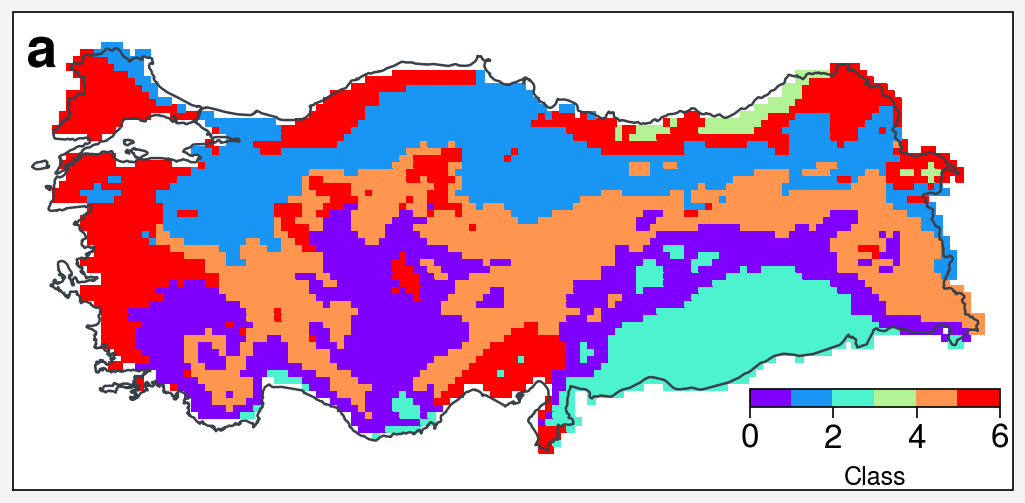

In [30]:
#%%capture

# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=10,
                            axwidth=5,
                            proj=lcc,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=-0.46,
                            wspace=-0.16,
                            sharey=0
                           )

# format whole figure
axs.format(abcloc='ul',
           #abcbbox = True,
           abc_kw={'size':20},
           abc=True,
           zorder=50
          )

# Turkey limits
axs.format(lonlim=(25.8, 45.1), 
           latlim=(35., 42.2), 
           longrid=False, 
           latgrid = False
          )

# format headers
#axs.format(rowlabels=col_names,
#           collabels=[fr'Reference - {season}', 
#                      fr'Projection - {season}']
#          )

# geographic axes
utils.plot_geographic_features(axs, 
                               graphic_no
                              )#
# cmap norm
cmap=plt.get_cmap('rainbow')
clevs = np.arange(0, 7, 1 
                       )
norm = BoundaryNorm(clevs,
                    ncolors=cmap.N, 
                    clip=True
                        )

mesh = axs[0].pcolormesh(results_xr['rlon'],
                    results_xr['rlat'],
                    results_xr['pred'],
                    cmap=cmap,
                    norm=norm,
                    transform=lcc,
                    zorder=20,
                                 )

# colorbar
axs[0].colorbar(mesh,
             label='Class',
             loc='lr', length=10,  # length is em widths
             tickminor=False, alpha=0.5,
             width=0.7,
             labelsize = 9,
             ticklabelsize = 12,
             frame=False,
             pad = 0.5,
             ticks=[0,1,2,3,4,5,6]
            )

#save figure
plt.savefig(fr'{path_general}/pictures/kmeans_BC_{n_clusters}region_{season}.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=300)

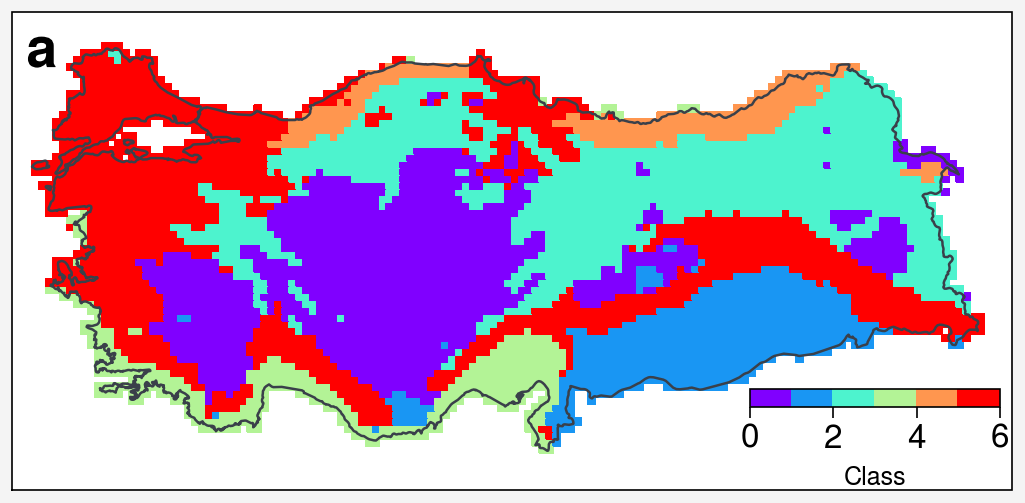

In [30]:
#%%capture

# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=10,
                            axwidth=5,
                            proj=lcc,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=-0.46,
                            wspace=-0.16,
                            sharey=0
                           )

# format whole figure
axs.format(abcloc='ul',
           #abcbbox = True,
           abc_kw={'size':20},
           abc=True,
           zorder=50
          )

# Turkey limits
axs.format(lonlim=(25.8, 45.1), 
           latlim=(35., 42.2), 
           longrid=False, 
           latgrid = False
          )

# format headers
#axs.format(rowlabels=col_names,
#           collabels=[fr'Reference - {season}', 
#                      fr'Projection - {season}']
#          )

# geographic axes
utils.plot_geographic_features(axs, 
                               graphic_no
                              )#
# cmap norm
cmap=plt.get_cmap('rainbow')
clevs = np.arange(0, 7, 1 
                       )
norm = BoundaryNorm(clevs,
                    ncolors=cmap.N, 
                    clip=True
                        )

mesh = axs[0].pcolormesh(results_xr['rlon'],
                    results_xr['rlat'],
                    results_xr['pred'],
                    cmap=cmap,
                    norm=norm,
                    transform=lcc,
                    zorder=20,
                                 )

# colorbar
axs[0].colorbar(mesh,
             label='Class',
             loc='lr', length=10,  # length is em widths
             tickminor=False, alpha=0.5,
             width=0.7,
             labelsize = 9,
             ticklabelsize = 12,
             frame=False,
             pad = 0.5,
             ticks=[0,1,2,3,4,5,6]
            )

#save figure
plt.savefig(fr'{path_general}/pictures/kmeans_BC_{n_clusters}region_{season}.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=300)